# Multi-Agent System For diagram update

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import subprocess

from dotenv import load_dotenv
from typing import List, Optional, Dict, Literal
from sqlalchemy import create_engine, text
from typing_extensions import Annotated, TypedDict

from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama
from langgraph.graph import END, StateGraph
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage

# from agents import history_node, aggregator_node, orchestrator_node, source_code_node, LaPSuMState



In [3]:
load_dotenv()

True

## Shared and Utilities

#### State Model

In [4]:
class LaPSuMState(TypedDict):
    # User query and orchestration context
    user_query: Annotated[Optional[str], "Original user query"]
    rewritten_query: Annotated[Optional[str], "Rewritten version of the query by the orchestrator"]

    # Source-related metadata
    repo_path: Annotated[Optional[str], "Path to the local git repository"]
    diagram: Annotated[Optional[str], "Current UML diagram in JSON format"]

    # Agent coordination
    required_agents: Annotated[List[Literal["history", "source_code"]], "List of agents needed to process the query"]
    responded_agents: Annotated[List[Literal["history", "source_code"]], "List of agents that have already responded"]

    # Optional: store intermediate responses for aggregation
    agent_responses: Annotated[Dict[str, str], "Responses from each agent keyed by agent name"]

### Helper functions

In [5]:
qwen = ChatOllama(model="qwen2.5")
deepseek = ChatGroq(model="deepseek-r1-distill-llama-70b")
llama = ChatGroq(model="llama-3.3-70b-versatile")

llms = {
    "orchestrator": deepseek,
    "source_code": llama,
    "history": qwen,
    "docs": qwen,
    "issues": qwen,
    "orchestrator": qwen,
    "aggregator": qwen,
    "discussion": qwen
    
}

## Agents and Tools

### History

In [6]:
@tool
def run_git_command(repo_path: str, command: str) -> str:
    """
    Run an arbitrary git command in the given repository path.
    
    Args:
        repo_path: Path to the Git repository.
        command: The git command to run (without the leading 'git'), e.g., 'log -10 --pretty=format:%h'
    
    Returns:
        The output of the command or an error message.
    """
    if not os.path.exists(os.path.join(repo_path, ".git")):
        return f"Error: {repo_path} is not a valid Git repository."

    try:
        result = subprocess.run(
            ["git"] + command.strip().split(),
            cwd=repo_path,
            capture_output=True,
            text=True,
            check=True
        )
        return result.stdout
    except subprocess.CalledProcessError as e:
        return f"Error running git command: {e.stderr}"

history_agent = create_react_agent(
    llms['history'],
    tools=[run_git_command],
    prompt="""
        You are a version control analysis assistant collaborating with a software researcher.
        
        Your role is to analyze the Git history of a local project using only the tools provided.

        Constraints:
        - Do not rely on prior knowledge or assumptions.
        - All information must be derived from Git history via the provided tools.
        - Begin your final answer with 'FINAL ANSWER'.

        Available Tool:
        - run_git_command(command): Run any git command against the local repo.

        Always refer to the repo using the path provided in 'repo_path'.
    """
)
def history_node(state: LaPSuMState) -> Command[Literal["orchestrator"]]:
    if "history" in state.get("responded_agents", []):
        return Command(update=state, goto="orchestrator")

    query = state.get("rewritten_query") or state.get("user_query") or ""
    repo_path = state.get("repo_path")

    # Pass the rewritten query and repo_path to the agent
    result = history_agent.invoke({
        "messages": [HumanMessage(content=query)],
        "repo_path": repo_path,
    })

    final_message = result["messages"][-1]
    state["agent_responses"]["history"] = final_message.content
    state["responded_agents"].append("history")

    # Tag the message so it's traceable in logs or UI
    result["messages"][-1] = AIMessage(content=final_message.content, name="history")

    return Command(update=state, goto="orchestrator")

### Source Code

In [7]:
engine = create_engine("sqlite:///uml-data.db")

@tool
def query_uml_database(sql: str) -> str:
    """Run a SQL query against the UML database. Return results as string."""
    with engine.connect() as conn:
        try:
            result = conn.execute(text(sql))
            rows = [dict(row) for row in result]
            return str(rows)
        except Exception as e:
            return f"SQL Error: {e}"

# ─────── Agent Schema-Aware Prompt ─────── #
SCHEMA_PROMPT = """
You are a software architecture assistant specialized in analyzing Java projects via UML databases.

You can use the following tool:
- query_uml_database(sql): Run SQL queries on the UML database.

The UML schema consists of:
- uml_class(id, name, package_name, is_abstract, is_interface, annotations, files, dom_id, display_name, summary, comments)
- uml_property(id, class_id, name, data_type, visibility, is_static, is_final, source_line, dom_id, annotations, comments, summary)
- uml_method(id, class_id, name, dom_id, return_type, visibility, is_static, is_abstract, starting_line, ending_line, source, annotations, display_name, comments, summary)
- uml_parameter(id, method_id, name, dom_id, data_type, display_name, annotations, comments, summary)
- uml_relationship(id, name, dom_id, source, target, type)
- uml_package(id, name, parent)

You will receive natural language queries and respond using this schema. If applicable, generate SQL and call the tool.
"""

# ─────── Create LangGraph UML Agent ─────── #
uml_agent = create_react_agent(
    llms["source_code"],  # Reuses same LLM
    tools=[query_uml_database],
    prompt=SCHEMA_PROMPT,
)

# ─────── Node for LangGraph ─────── #
def source_code_node(state: LaPSuMState) -> Command[Literal["orchestrator"]]:
    if "source_code" in state.get("responded_agents", []):
        return Command(update=state, goto="orchestrator")

    query = state.get("rewritten_query") or state.get("user_query") or ""
    result = uml_agent.invoke({"messages": [HumanMessage(content=query)]})
    final_message = result["messages"][-1]

    state["agent_responses"]["source_code"] = final_message.content
    state["responded_agents"].append("source_code")
    result["messages"][-1] = AIMessage(content=final_message.content, name="source_code")

    return Command(update=state, goto="orchestrator")

### Aggregator

In [8]:
aggregator_agent = create_react_agent(
    llms['aggregator'],
    tools=[],
    prompt=
        """
        You are an aggregation assistant.

        Your role is to combine and summarize responses provided by your colleague agents.
        Only use the content already provided in the current conversation state.

        Rules:
        - DO NOT infer or invent any information.
        - DO NOT ask the user follow-up questions.
        - DO NOT make assumptions or guesses.
        - If the information is incomplete or missing, say so directly.
        - If the answer is complete, prefix your final output with: 'FINAL ANSWER'.

        You are expected to clearly and accurately synthesize the responses to help the user.
        """
    ,
)
def aggregator_node(state: LaPSuMState) -> Command[Literal[END]]:
    # Skip if already finalized
    for response in state.get("agent_responses", {}).values():
        if "FINAL ANSWER" in response:
            return Command(update=state, goto=END)

    # Build conversation context from agent responses
    messages = [
        HumanMessage(content=state["rewritten_query"] or state["user_query"]),
    ]
    for agent_name in state.get("required_agents", []):
        if agent_name in state.get("agent_responses", {}):
            messages.append(AIMessage(
                content=state["agent_responses"][agent_name],
                name=agent_name
            ))

    # Invoke the aggregator agent
    result = aggregator_agent.invoke({"messages": messages})

    final_message = result["messages"][-1]

    # If it contains 'FINAL ANSWER', the workflow should end
    goto = END if "FINAL ANSWER" in final_message.content else END  # optionally re-orchestrate if not final

    # Save the aggregated message
    return Command(update={
        "agent_responses": {
            **state.get("agent_responses", {}),
            "aggregator": final_message.content
        }
    }, goto=goto)

### Orchestrator

In [9]:
def orchestrator_node(state: LaPSuMState) -> Command[Literal["history", "source_code", "aggregator"]]:
    # Skip orchestration if aggregation is already triggered or all agents have responded
    if state.get("user_query") is None or set(state.get("required_agents", [])) == set(state.get("responded_agents", [])):
        return Command(update=state, goto="aggregator")

    # Run LLM-based query rewriting and planning
    task_analysis = llms['orchestrator'].invoke([
        HumanMessage(
            content=(
                "You are a query orchestrator and planning assistant in a multi-agent system that helps answer software-related questions.\n"
                "You have access to these agents:\n"
                "- 'source_code': understands code logic, structure, classes, relationships.\n"
                "- 'history': analyzes git history, commit changes, authorship, file evolution.\n\n"
                "Your task is to:\n"
                "1. Rewrite the user's query to make it clearer and better suited for agents.\n"
                "2. Create a step-by-step plan using available tools/agents.\n"
                "3. Identify which agents are required to complete the plan.\n\n"
                f"User Query: {state['user_query']}\n\n"
                "Respond in JSON format like this:\n"
                "{\n"
                '  "rewritten_query": "....",\n'
                '  "required_agents": ["source_code", "history"],\n'
                '  "plan": "1. Use get_classes to find method location.\\n2. Use get_source to extract code.\\n3. Use history agent to trace the commit."\n'
                "}"
            )
        )
    ])

    parsed_response = json.loads(task_analysis.content)

    # Extract orchestration fields
    state["rewritten_query"] = parsed_response.get("rewritten_query", state["user_query"])
    state["required_agents"] = parsed_response.get("required_agents", [])
    state["responded_agents"] = []
    state["agent_responses"] = {}

    # Optional: add the plan to message history so agents can reason over it
    plan = parsed_response.get("plan")
    if plan:
        plan_message = HumanMessage(content=f"Plan:\n{plan}", name="planner")
        state["messages"] = [plan_message] + state.get("messages", [])

    # If no agents are required, go to aggregator
    if not state["required_agents"]:
        return Command(update=state, goto="aggregator")

    # Route to first required agent
    next_agent = state["required_agents"][0]
    return Command(update=state, goto=next_agent)


## Graph

In [10]:
# Replace MessagesState with LaPSuMState
workflow = StateGraph(LaPSuMState)

# Add nodes
workflow.add_node("orchestrator", orchestrator_node)
workflow.add_node("aggregator", aggregator_node)
workflow.add_node("history", history_node)
workflow.add_node("source_code", source_code_node)

# Define edges
workflow.set_entry_point("orchestrator")

# Agent nodes return to orchestrator after processing
workflow.add_edge("source_code", "orchestrator")
workflow.add_edge("history", "orchestrator")

# Orchestrator eventually routes to aggregator once all agents respond
workflow.add_edge("aggregator", END)

# Compile the graph
graph = workflow.compile()

### Visualize

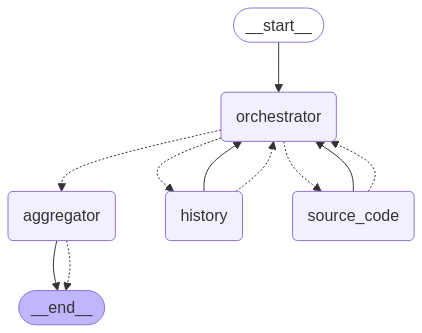

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


# Run Queries

In [12]:
events = graph.stream(
    {
        "user_query": "Filter out classes with less than 5 methods",
        "rewritten_query": None,
        "repo_path": "/Users/yoseph/Work/Personal/keycloak",
        "diagram": None,
        "required_agents": [],
        "responded_agents": [],
        "agent_responses": {},
    },
    {"recursion_limit": 100},
)

for event in events:
    first_key = next(iter(event))
    response = event[first_key]
    if "agent_responses" in response and response["agent_responses"].get("aggregator"):
        print(f"{first_key}: {response['agent_responses']['aggregator']}")
    else:
        print(f"{first_key}: (intermediate state)")
    print('----')

orchestrator: (intermediate state)
----
aggregator: I need more context about which specific classes you're referring to or where these classes are located. Could you please provide details on the source of these classes or any relevant code snippets? Without this information, I cannot filter out classes based on their method count.
----
